# Bingham Model: Yield Stress Fluid Fitting

## What is This?

This notebook demonstrates the **Bingham plastic model**, which describes materials requiring a **minimum stress (yield stress) to initiate flow**. Below the yield stress, the material behaves as a rigid solid; above it, the material flows with constant viscosity. This simple 2-parameter model captures the essence of **viscoplastic behavior**.

**Why Bingham?** It's the simplest model for yield stress fluids (toothpaste, mayonnaise, concrete, drilling mud), providing analytical solutions for pipe flow, coating thickness, and mixing power calculations.

## The Bingham Plastic Model

**Constitutive Equation:**
$$\sigma(\dot{\gamma}) = \begin{cases}
\sigma_y \operatorname{sgn}(\dot{\gamma}) & \text{if } |\sigma| \leq \sigma_y \text{ (unyielded)} \\
\sigma_y + \eta_p \dot{\gamma} & \text{if } |\sigma| > \sigma_y \text{ (yielded)}
\end{cases}$$

**Apparent Viscosity:**
$$\eta(\dot{\gamma}) = \frac{\sigma_y}{|\dot{\gamma}|} + \eta_p \quad \text{for } |\dot{\gamma}| > 0$$

where:
- $\sigma_y$ = yield stress (Pa) — minimum stress required to initiate flow
- $\eta_p$ = plastic viscosity (Pa·s) — constant viscosity above yield (Newtonian post-yield)

**Physical Meaning:**
- Below yield ($\sigma < \sigma_y$): Rigid solid behavior (no flow)
- Above yield ($\sigma > \sigma_y$): Linear viscous flow with slope $\eta_p$
- Apparent viscosity diverges as $\dot{\gamma} \to 0$

**Microstructural Origin of Yield Stress:**
- Particle networks (clay suspensions, cement)
- Attractive interactions (van der Waals, electrostatic)
- Entangled structures (fiber networks)
- Jamming transitions (dense suspensions)

> **Handbook:** See [Bingham Model](../../docs/source/models/flow/bingham.rst) for yield stress determination methods, [Flow Models Overview](../../docs/source/models/flow/index.rst) for model hierarchy, and Coussot (2005) *Rheometry of Pastes, Suspensions, and Granular Materials* for industrial applications.

## Learning Objectives

- Fit Bingham model to flow curve data (σ vs γ̇)
- Detect and interpret yield stress from flow curves
- Understand viscoplastic behavior (rigid below yield, Newtonian above)
- Bayesian inference for yield stress uncertainty quantification
- Apply to process design (pumping, coating, mixing)

**Prerequisites:** Basic rheology, complete 01-maxwell-fitting.ipynb

**Estimated Time:** 30-35 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import time
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import Bingham
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
print("✓ JAX float64 enabled")

np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')

import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


✓ JAX float64 enabled


## Bingham Theory

The Bingham model describes materials requiring minimum stress (yield stress) to flow:

**Constitutive Equation:**
$$\sigma(\dot{\gamma}) = \sigma_y + \eta_p \dot{\gamma} \quad \text{for } \sigma > \sigma_y$$
$$\dot{\gamma} = 0 \quad \text{for } \sigma \leq \sigma_y$$

**Parameters:**
- $\sigma_y$ = yield stress (Pa) - minimum stress to initiate flow
- $\eta_p$ = plastic viscosity (Pa·s) - constant viscosity above yield

**Applications:** Toothpaste, mayonnaise, drilling mud, concrete

In [3]:
# True parameters
sigma_y_true = 50.0  # Pa
eta_p_true = 1.0     # Pa·s

print(f"True Parameters:")
print(f"  σ_y  = {sigma_y_true:.1f} Pa")
print(f"  η_p  = {eta_p_true:.2f} Pa·s")

# Shear rate array
gamma_dot = np.logspace(-1, 2, 40)  # 0.1 to 100 s⁻¹

# True stress
sigma_true = sigma_y_true + eta_p_true * gamma_dot

# Add noise
noise_level = 0.02
noise = np.random.normal(0, noise_level * sigma_true)
sigma_noisy = sigma_true + noise

print(f"\nData: {len(gamma_dot)} points, noise {noise_level*100:.1f}%")

True Parameters:
  σ_y  = 50.0 Pa
  η_p  = 1.00 Pa·s

Data: 40 points, noise 2.0%


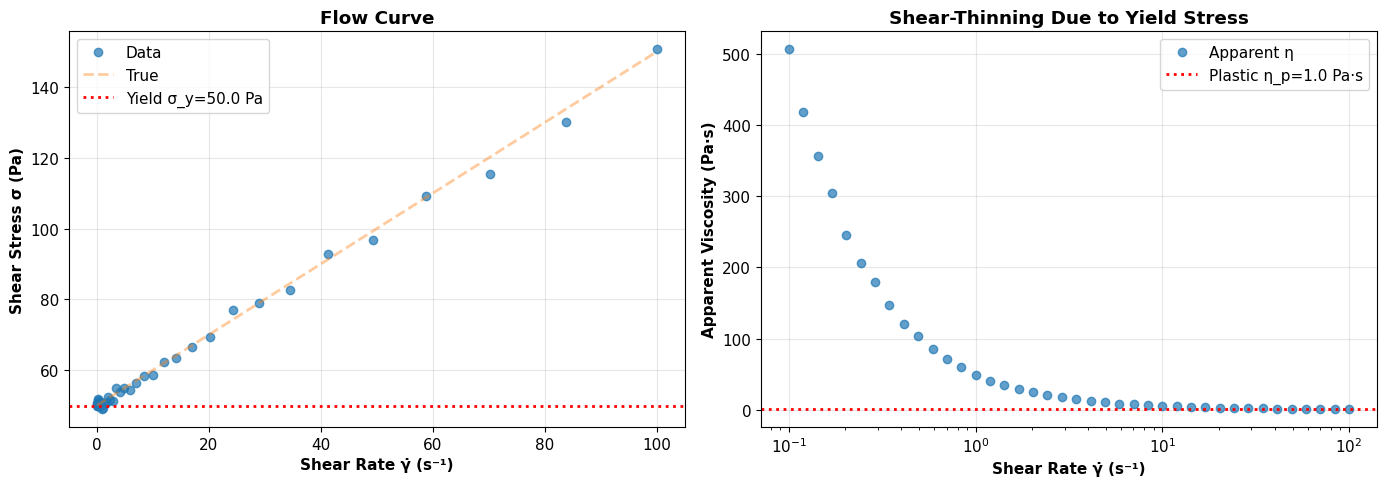

In [4]:
# Visualize flow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(gamma_dot, sigma_noisy, 'o', alpha=0.7, label='Data')
ax1.plot(gamma_dot, sigma_true, '--', linewidth=2, alpha=0.4, label='True')
ax1.axhline(sigma_y_true, color='red', linestyle=':', linewidth=2, label=f'Yield σ_y={sigma_y_true} Pa')
ax1.set_xlabel('Shear Rate γ̇ (s⁻¹)', fontweight='bold')
ax1.set_ylabel('Shear Stress σ (Pa)', fontweight='bold')
ax1.set_title('Flow Curve', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Viscosity
eta_apparent = sigma_noisy / gamma_dot
ax2.semilogx(gamma_dot, eta_apparent, 'o', alpha=0.7, label='Apparent η')
ax2.axhline(eta_p_true, color='red', linestyle=':', linewidth=2, label=f'Plastic η_p={eta_p_true} Pa·s')
ax2.set_xlabel('Shear Rate γ̇ (s⁻¹)', fontweight='bold')
ax2.set_ylabel('Apparent Viscosity (Pa·s)', fontweight='bold')
ax2.set_title('Shear-Thinning Due to Yield Stress', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)


## Fitting (Linear Regression)

Bingham model is linear: σ = σ_y + η_p·γ̇, so we can use simple linear regression.

In [5]:
model = Bingham()
model.fit(gamma_dot, sigma_noisy)

sigma_y_fit = model.parameters.get_value('sigma_y')
eta_p_fit = model.parameters.get_value('eta_p')

print("="*60)
print("FITTED PARAMETERS")
print("="*60)
print(f"σ_y = {sigma_y_fit:.2f} Pa (true: {sigma_y_true:.2f})")
print(f"η_p = {eta_p_fit:.3f} Pa·s (true: {eta_p_true:.3f})")
print(f"\nErrors: σ_y {abs(sigma_y_fit-sigma_y_true)/sigma_y_true*100:.2f}%, η_p {abs(eta_p_fit-eta_p_true)/eta_p_true*100:.2f}%")
print("="*60)

FITTED PARAMETERS
σ_y = 50.08 Pa (true: 50.00)
η_p = 0.979 Pa·s (true: 1.000)

Errors: σ_y 0.16%, η_p 2.07%


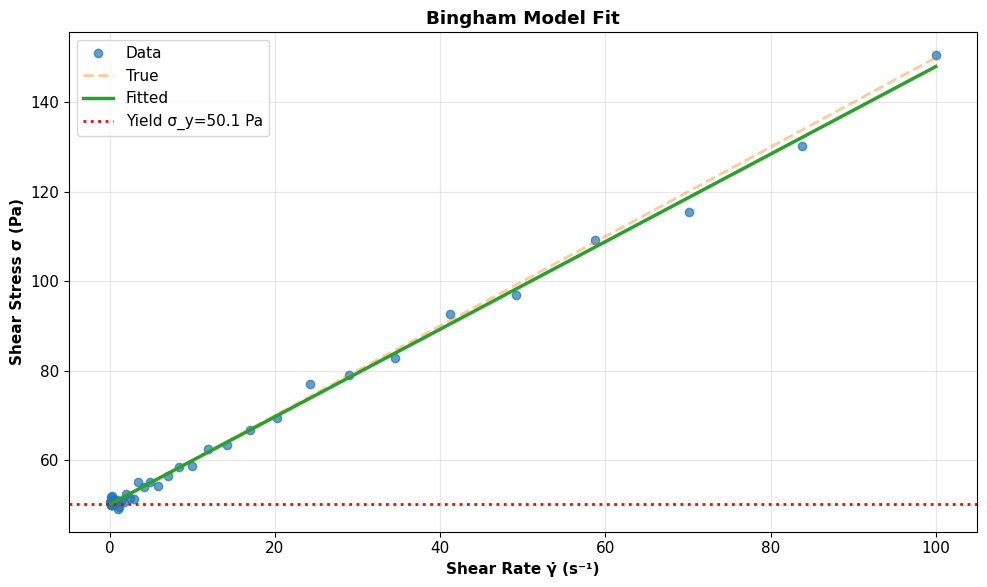

R² = 0.996998


In [6]:
# Visualize fit
sigma_pred = model.predict(gamma_dot)

fig = plt.figure(figsize=(10, 6))
plt.plot(gamma_dot, sigma_noisy, 'o', alpha=0.7, label='Data')
plt.plot(gamma_dot, sigma_true, '--', linewidth=2, alpha=0.4, label='True')
plt.plot(gamma_dot, sigma_pred, '-', linewidth=2.5, label='Fitted')
plt.axhline(sigma_y_fit, color='red', linestyle=':', linewidth=2, label=f'Yield σ_y={sigma_y_fit:.1f} Pa')
plt.xlabel('Shear Rate γ̇ (s⁻¹)', fontweight='bold')
plt.ylabel('Shear Stress σ (Pa)', fontweight='bold')
plt.title('Bingham Model Fit', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

r2 = 1 - np.sum((sigma_noisy - sigma_pred)**2) / np.sum((sigma_noisy - np.mean(sigma_noisy))**2)
print(f"R² = {r2:.6f}")


## Residual Analysis

Residual analysis reveals whether the Bingham model captures all systematic trends in the data. Random residuals within the noise band confirm a good fit.

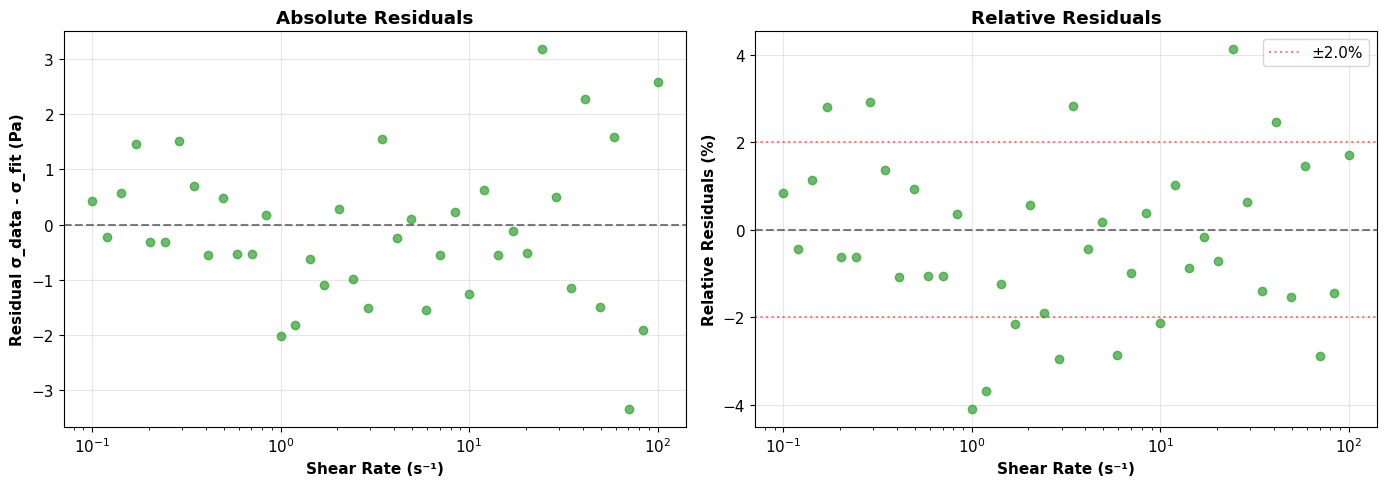

Mean |residual|: 1.55%
Max  |residual|: 4.12%


In [7]:
# Residual analysis
residuals = sigma_noisy - sigma_pred
relative_residuals = residuals / sigma_noisy * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Absolute residuals
ax1.semilogx(gamma_dot, residuals, 'o', alpha=0.7, color='#2ca02c')
ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Shear Rate (s⁻¹)', fontweight='bold')
ax1.set_ylabel('Residual σ_data - σ_fit (Pa)', fontweight='bold')
ax1.set_title('Absolute Residuals', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Relative residuals
ax2.semilogx(gamma_dot, relative_residuals, 'o', alpha=0.7, color='#2ca02c')
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(noise_level*100, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'±{noise_level*100:.1f}%')
ax2.axhline(-noise_level*100, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax2.set_xlabel('Shear Rate (s⁻¹)', fontweight='bold')
ax2.set_ylabel('Relative Residuals (%)', fontweight='bold')
ax2.set_title('Relative Residuals', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Mean |residual|: {np.mean(np.abs(relative_residuals)):.2f}%")
print(f"Max  |residual|: {np.max(np.abs(relative_residuals)):.2f}%")

## Bayesian Inference

Quantify yield stress uncertainty - critical for process design!

In [8]:
print("Running Bayesian inference...\n")

result = model.fit_bayesian(
    gamma_dot, sigma_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={
        'sigma_y': sigma_y_fit,
        'eta_p': eta_p_fit
    }
)

print("Complete!")

Running Bayesian inference...



/Users/b80985/Projects/rheojax/rheojax/core/base.py:544: UserWarning: test_mode not specified. Defaulting to 'relaxation'. For correct posteriors, pass RheoData with metadata['test_mode'] or specify test_mode explicitly.
  result = super().fit_bayesian(


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<27:24,  1.82it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:  18%|█▊        | 525/3000 [00:00<00:02, 1084.22it/s, 7 steps of size 2.04e-01. acc. prob=0.98]

sample:  38%|███▊      | 1155/3000 [00:00<00:00, 2272.61it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample:  60%|█████▉    | 1787/3000 [00:00<00:00, 3266.01it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample:  81%|████████  | 2418/3000 [00:00<00:00, 4056.43it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2877.74it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

Complete!


In [9]:
summary = result.summary
diagnostics = result.diagnostics
credible = model.get_credible_intervals(result.posterior_samples, 0.95)

print("="*60)
print("POSTERIOR SUMMARY")
print("="*60)
print(f"\nσ_y = {summary['sigma_y']['mean']:.2f} ± {summary['sigma_y']['std']:.2f} Pa")
print(f"η_p = {summary['eta_p']['mean']:.3f} ± {summary['eta_p']['std']:.3f} Pa·s")
print(f"\n95% CI σ_y: [{credible['sigma_y'][0]:.2f}, {credible['sigma_y'][1]:.2f}] Pa")
print(f"95% CI η_p: [{credible['eta_p'][0]:.3f}, {credible['eta_p'][1]:.3f}] Pa·s")
print(f"\nR-hat: σ_y={diagnostics['r_hat']['sigma_y']:.4f}, η_p={diagnostics['r_hat']['eta_p']:.4f}")
print(f"ESS: σ_y={diagnostics['ess']['sigma_y']:.0f}, η_p={diagnostics['ess']['eta_p']:.0f}")
print("="*60)

print(f"\n✓ Yield stress uncertainty: ±{summary['sigma_y']['std']/summary['sigma_y']['mean']*100:.1f}%")

POSTERIOR SUMMARY

σ_y = 49.91 ± 0.26 Pa
η_p = 0.982 ± 0.009 Pa·s

95% CI σ_y: [49.41, 50.41] Pa
95% CI η_p: [0.964, 0.999] Pa·s

R-hat: σ_y=0.9995, η_p=0.9995
ESS: σ_y=1112, η_p=1133

✓ Yield stress uncertainty: ±0.5%


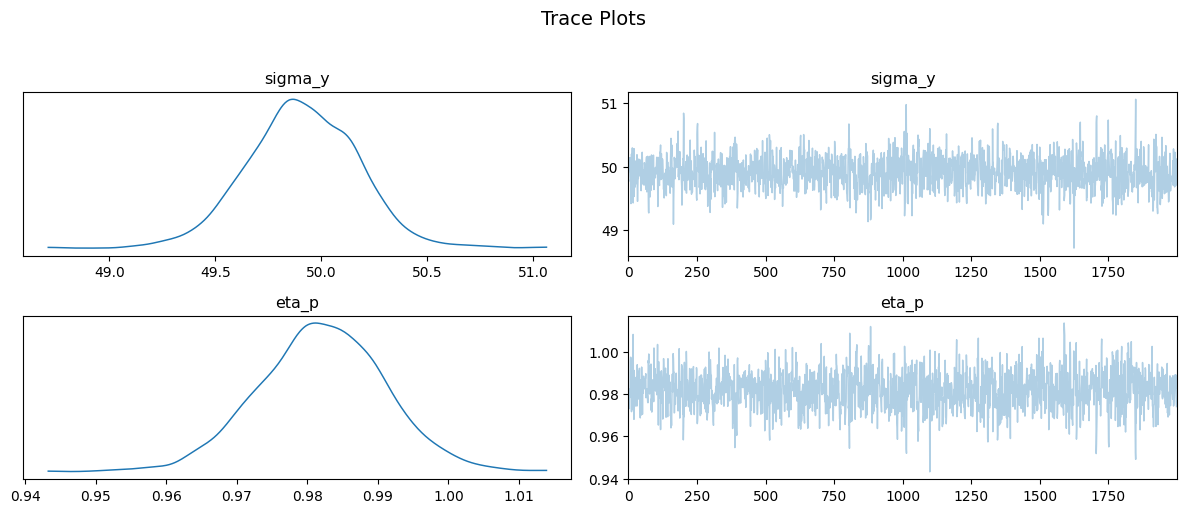

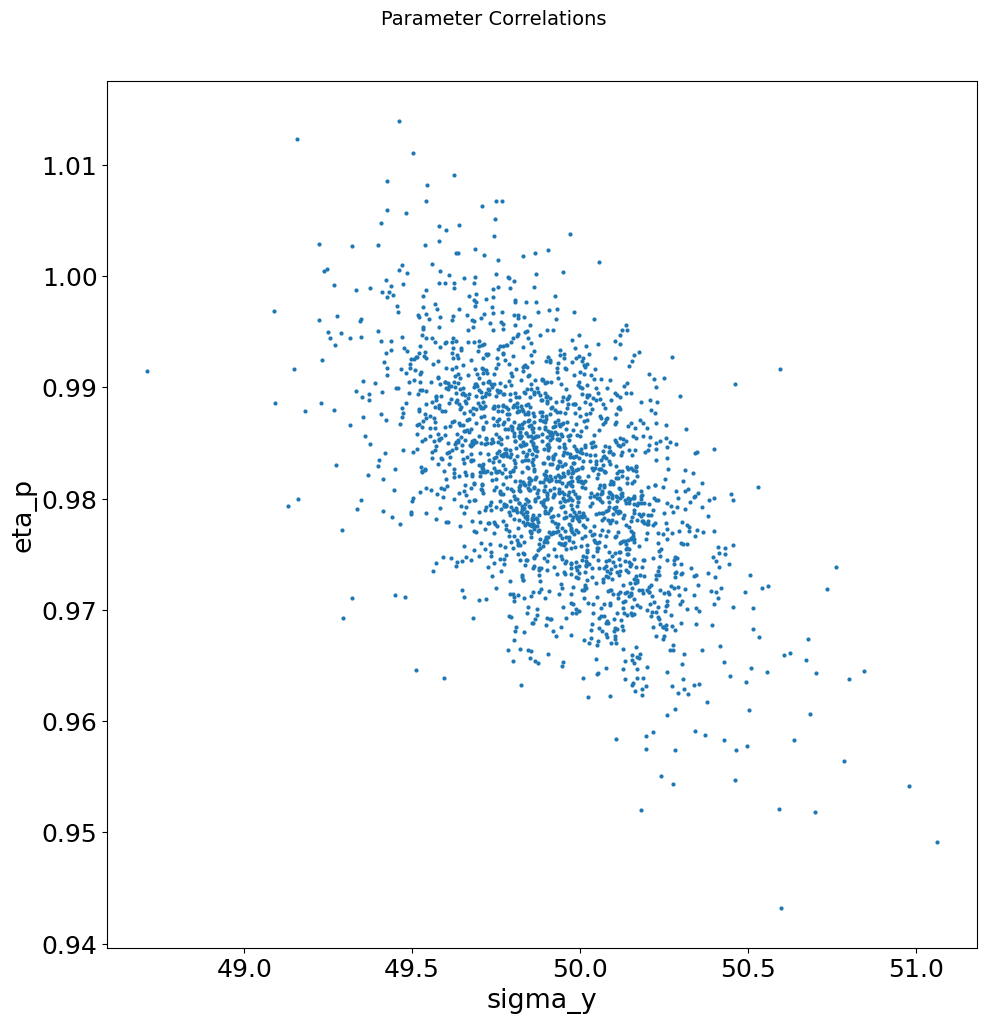

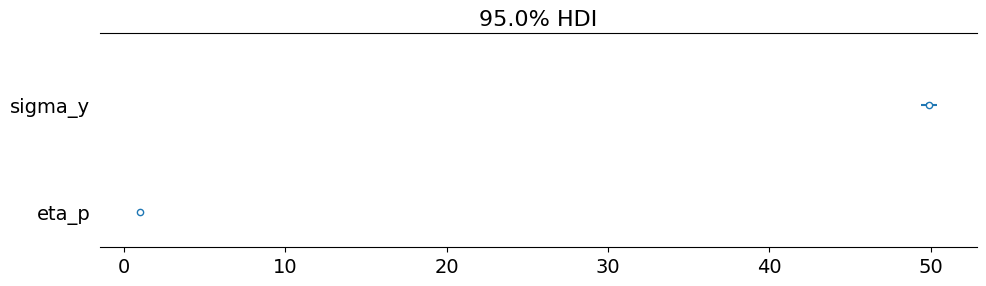

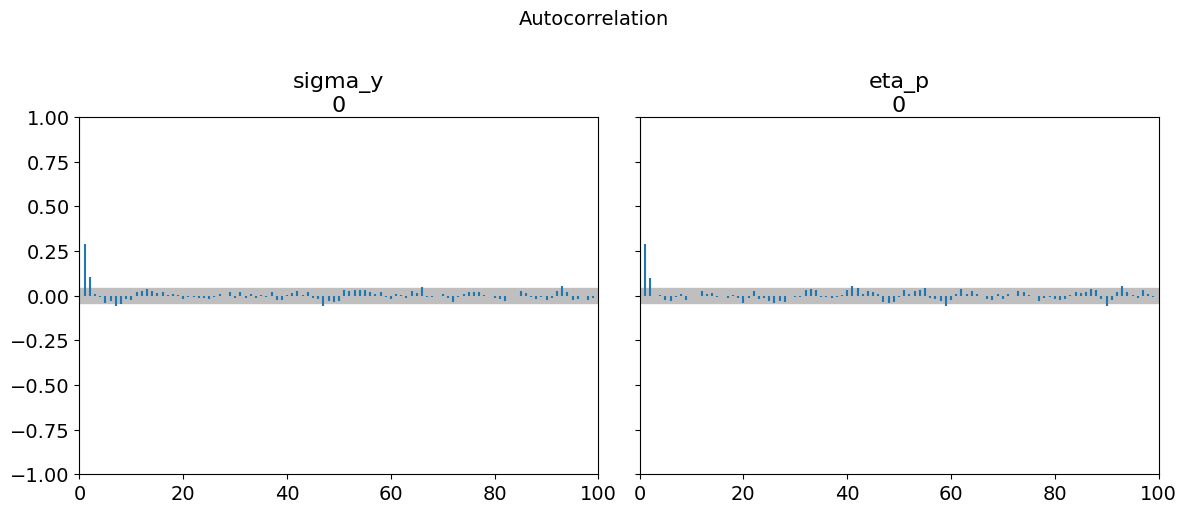

In [10]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(result, ['sigma_y', 'eta_p'], fast_mode=FAST_MODE)

### Convergence Diagnostic Interpretation

| Metric | Target | Meaning |
|--------|--------|---------|
| **R-hat < 1.01** | Chains converged | Multiple chains agree on posterior |
| **ESS > 400** | Sufficient samples | Independent information content |
| **Divergences < 1%** | Well-behaved sampler | No numerical issues in posterior geometry |

**For yield stress fluids:** The σ_y posterior is particularly important — its width directly determines the **safety factor** needed for process design (pumping pressure, coating thickness). A narrow credible interval means precise process control.

## Key Takeaways

### Main Concepts

1. **Yield Stress Behavior:**
   - σ_y = minimum stress for flow initiation (critical for process design)
   - Below yield: rigid solid (zero shear rate)
   - Above yield: Newtonian flow (constant η_p)
   - Essential for understanding sedimentation, sagging, and pumpability

2. **Apparent Viscosity:**
   - η_app = σ_y/γ̇ + η_p diverges as γ̇ → 0
   - Creates "shear-thinning" appearance without true structural change
   - Distinguishes from true shear-thinning (Power-Law, Carreau)

3. **Linear Model:**
   - σ = σ_y + η_p·γ̇ is linear above yield
   - Simple linear regression for parameter estimation
   - Extrapolate to γ̇=0 to find σ_y (intercept)

4. **Bayesian Uncertainty:**
   - Critical for safety margins (yield stress uncertainty → pumping pressure safety factor)
   - σ_y confidence interval determines process reliability
   - Use for quality control (track σ_y batch-to-batch)

### When to Use Bingham Model

**Appropriate for:**
- ✓ Materials with clear yield stress
- ✓ Newtonian behavior above yield (constant η_p)
- ✓ Toothpaste, mayonnaise, ketchup, mustard
- ✓ Cement pastes, drilling mud, concrete slurries
- ✓ Process design (pipe flow, coating thickness, mixing power)

**Consider alternatives for:**
- ✗ No yield stress → Power-Law or Carreau models
- ✗ Shear-thinning/thickening above yield → Herschel-Bulkley (σ = σ_y + K·γ̇^n)
- ✗ Time-dependent structure → Thixotropic models (Fluidity, DMT)
- ✗ Stress overshoot in startup → Viscoelastic models (Saramito EVP)

### Common Pitfalls

1. **Apparent vs True Yield Stress:**
   - Many "yield stress" fluids are actually highly shear-thinning (no true yield)
   - Check with controlled stress ramp or vane method
   - Compare multiple yield determination methods

2. **Wall Slip:**
   - Yield stress materials prone to slip at smooth walls
   - Use vane geometry or serrated plates
   - Verify with multiple geometries

3. **Pre-Yield Data:**
   - Low γ̇ data noisy (torque resolution limit)
   - Exclude data below γ̇ < 0.01 s⁻¹ or use robust fitting
   - Focus on post-yield region for reliable η_p

## Further Reading

### Related Models
- [**Bingham Model Handbook**](../../docs/source/models/flow/bingham.rst) — Comprehensive theory, experimental protocols, and engineering applications (pipe flow, Buckingham-Reiner equation)
- [**Herschel-Bulkley Model**](../../docs/source/models/flow/herschel_bulkley.rst) — Generalization with power-law post-yield (σ = σ_y + K·γ̇^n)
- [**Power-Law Model**](05-power-law-fitting.ipynb) — Zero-yield limit for simple shear-thinning
- [**Flow Models Overview**](../../docs/source/models/flow/index.rst) — Complete flow curve model hierarchy

### Key References
- **Bingham, E.C. (1922)**. *Fluidity and Plasticity*. McGraw-Hill. — Original description of the Bingham plastic model
- **Barnes, H.A. (1999)**. "The yield stress—a review or 'παντα ρει'—everything flows?" *J. Non-Newtonian Fluid Mech.*, 81, 133–178. — Critical review of yield stress concept
- **Coussot, P. (2005)**. *Rheometry of Pastes, Suspensions, and Granular Materials*. Wiley. — Practical guide to yield stress measurement
- **Balmforth, N.J., Frigaard, I.A., & Ovarlez, G. (2014)**. "Yielding to stress: Recent developments in viscoplastic fluid mechanics." *Annu. Rev. Fluid Mech.*, 46, 121–146. — Modern theoretical developments

### Advanced Workflows
- [**Yield Stress Comparison**](../advanced/02-yield-stress-comparison.ipynb) — Compare Bingham, Herschel-Bulkley, and Casson models
- [**Thixotropic Models**](../../docs/source/models/dmt/index.rst) — Time-dependent yield stress (DMT, Fluidity models)
- [**SRFS Transform**](../../docs/source/transforms/srfs.rst) — Strain-rate frequency superposition for flow curves

## Next Steps

**Continue the Basic Series:**
1. **[05-power-law-fitting.ipynb](05-power-law-fitting.ipynb)** — Shear-thinning without yield stress (η = K·γ̇^(n-1))

**Explore Yield Stress Materials:**
- [**Herschel-Bulkley Model**](../../docs/source/models/flow/herschel_bulkley.rst) — Power-law post-yield behavior
- [**Casson Model**](../../docs/source/models/flow/casson.rst) — Alternative yield stress model for blood/chocolate

In [11]:
import sys

import rheojax

print(f"Python: {sys.version}")
print(f"RheoJAX: {rheojax.__version__}")

Python: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
RheoJAX: 0.6.0
